In [14]:
import pandas as pd
from zipfile import ZipFile
import numpy as np
import torch
from IPython.display import Image, clear_output
import yaml
import glob
from IPython.display import Image, display
from google.colab import drive

In [15]:
!git clone https://github.com/ultralytics/yolov5  
%cd yolov5
!git reset --hard 886f1c03d839575afecb059accf74296fad395b6

Cloning into 'yolov5'...
remote: Enumerating objects: 97, done.
remote: Counting objects: 100% (97/97), done.
remote: Compressing objects: 100% (71/71), done.
remote: Total 5403 (delta 57), reused 58 (delta 26), pack-reused 5306
Receiving objects: 100% (5403/5403), 8.05 MiB | 31.72 MiB/s, done.
Resolving deltas: 100% (3682/3682), done.
/content/yolov5/yolov5
HEAD is now at 886f1c0 DDP after autoanchor reorder (#2421)


In [16]:
!pip install -qr requirements.txt

In [17]:
print('Setup complete. Using torch %s %s' % (torch.__version__, torch.cuda.get_device_properties(0) if torch.cuda.is_available() else 'CPU'))

Setup complete. Using torch 1.8.0+cu101 CPU


In [ ]:
%cd /content
!curl -L "https://app.roboflow.com/ds/vksXlcqSx3?key=YhaQ0yc40M" > roboflow.zip; unzip roboflow.zip; rm roboflow.zip

/content
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   896  100   896    0     0   1870      0 --:--:-- --:--:-- --:--:--  1870
100 15.0M  100 15.0M    0     0  20.3M      0 --:--:-- --:--:-- --:--:-- 60.9M
Archive:  roboflow.zip
 extracting: README.roboflow.txt     
 extracting: data.yaml               
   creating: test/
   creating: test/images/
 extracting: test/images/car_104_jpg.rf.4c68b6b953c4a63ce5e77580406330f9.jpg  
 extracting: test/images/car_113_jpg.rf.17c823f817d4681ca09865d7a17521cf.jpg  
 extracting: test/images/car_122_jpg.rf.6913d4c557490a4fdcb3bc291fdbbc06.jpg  
 extracting: test/images/car_13_jpg.rf.18bd769d9bc52c91b4fa67489a503130.jpg  
 extracting: test/images/car_142_jpg.rf.823a46045aa951b813cc09216a334ce8.jpg  
 extracting: test/images/car_146_jpg.rf.fe1196d66e7790557e639fa35f92a797.jpg  
 extracting: test/images/car_157_jpg.rf.b3dfa1004e437f6786

In [ ]:
%cat data.yaml

train: ../train/images
val: ../valid/images

nc: 1
names: ['license_plate']

In [ ]:
%cat /content/data.yaml

train: ../train/images
val: ../valid/images

nc: 1
names: ['license_plate']

In [ ]:
with open("/content/data.yaml", 'r') as stream:
    num_classes = str(yaml.safe_load(stream)['nc'])

In [ ]:
%cat /content/yolov5/models/yolov5s.yaml

# parameters
nc: 80  # number of classes
depth_multiple: 0.33  # model depth multiple
width_multiple: 0.50  # layer channel multiple

# anchors
anchors:
  - [10,13, 16,30, 33,23]  # P3/8
  - [30,61, 62,45, 59,119]  # P4/16
  - [116,90, 156,198, 373,326]  # P5/32

# YOLOv5 backbone
backbone:
  # [from, number, module, args]
  [[-1, 1, Focus, [64, 3]],  # 0-P1/2
   [-1, 1, Conv, [128, 3, 2]],  # 1-P2/4
   [-1, 3, C3, [128]],
   [-1, 1, Conv, [256, 3, 2]],  # 3-P3/8
   [-1, 9, C3, [256]],
   [-1, 1, Conv, [512, 3, 2]],  # 5-P4/16
   [-1, 9, C3, [512]],
   [-1, 1, Conv, [1024, 3, 2]],  # 7-P5/32
   [-1, 1, SPP, [1024, [5, 9, 13]]],
   [-1, 3, C3, [1024, False]],  # 9
  ]

# YOLOv5 head
head:
  [[-1, 1, Conv, [512, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 6], 1, Concat, [1]],  # cat backbone P4
   [-1, 3, C3, [512, False]],  # 13

   [-1, 1, Conv, [256, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 4], 1, Concat, [1]],  # cat backbone P3
   [-1, 3, C

In [ ]:
from IPython.core.magic import register_line_cell_magic
@register_line_cell_magic
def writetemplate(line, cell):
    with open(line, 'w') as f:
        f.write(cell.format(**globals()))

In [ ]:
%%writetemplate /content/yolov5/models/custom_yolov5s.yaml

nc: {num_classes}
depth_multiple: 0.33
width_multiple: 0.50

anchors:
  - [10,13, 16,30, 33,23]  
  - [30,61, 62,45, 59,119] 
  - [116,90, 156,198, 373,326] 

backbone:

  [[-1, 1, Focus, [64, 3]],  
   [-1, 1, Conv, [128, 3, 2]],  
   [-1, 3, BottleneckCSP, [128]],
   [-1, 1, Conv, [256, 3, 2]], 
   [-1, 9, BottleneckCSP, [256]],
   [-1, 1, Conv, [512, 3, 2]], 
   [-1, 9, BottleneckCSP, [512]],
   [-1, 1, Conv, [1024, 3, 2]],
   [-1, 1, SPP, [1024, [5, 9, 13]]],
   [-1, 3, BottleneckCSP, [1024, False]],
  ]

head:
  [[-1, 1, Conv, [512, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 6], 1, Concat, [1]],  
   [-1, 3, BottleneckCSP, [512, False]], 

   [-1, 1, Conv, [256, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 4], 1, Concat, [1]],  
   [-1, 3, BottleneckCSP, [256, False]], 

   [-1, 1, Conv, [256, 3, 2]],
   [[-1, 14], 1, Concat, [1]], 
   [-1, 3, BottleneckCSP, [512, False]],  

   [-1, 1, Conv, [512, 3, 2]],
   [[-1, 10], 1, Concat, [1]],  
   [-1, 3, BottleneckCSP, [1024, False]],  

   [[17, 20, 23], 1, Detect, [nc, anchors]], 
  ]

In [12]:
%%time
%cd /content/yolov5/
!python train.py --img 256 --batch 32 --epochs 1 --data '../data.yaml' --cfg ./models/custom_yolov5s.yaml --weights '' --name yolov5s_results  --cache

/content/yolov5
github: ⚠️ WARNING: code is out of date by 4 commits. Use 'git pull' to update or 'git clone https://github.com/ultralytics/yolov5' to download latest.
YOLOv5 v4.0-126-g886f1c0 torch 1.8.0+cu101 CPU

Namespace(adam=False, batch_size=32, bucket='', cache_images=True, cfg='./models/custom_yolov5s.yaml', data='../data.yaml', device='', entity=None, epochs=1, evolve=False, exist_ok=False, global_rank=-1, hyp='data/hyp.scratch.yaml', image_weights=False, img_size=[256, 256], linear_lr=False, local_rank=-1, log_artifacts=False, log_imgs=16, multi_scale=False, name='yolov5s_results', noautoanchor=False, nosave=False, notest=False, project='runs/train', quad=False, rect=False, resume=False, save_dir='runs/train/yolov5s_results', single_cls=False, sync_bn=False, total_batch_size=32, weights='', workers=8, world_size=1)
wandb: Install Weights & Biases for YOLOv5 logging with 'pip install wandb' (recommended)
Start Tensorboard with "tensorboard --logdir runs/train", view at http:/

In [ ]:
!git clone https://github.com/ultralytics/yolov5

Cloning into 'yolov5'...
remote: Enumerating objects: 97, done.
remote: Counting objects: 100% (97/97), done.
remote: Compressing objects: 100% (71/71), done.
remote: Total 5403 (delta 57), reused 56 (delta 26), pack-reused 5306
Receiving objects: 100% (5403/5403), 8.05 MiB | 21.70 MiB/s, done.
Resolving deltas: 100% (3678/3678), done.


In [ ]:
%%time
%cd /content/yolov5/
!python train.py --img 256 --batch 32 --epochs 100 --data '../data.yaml' --cfg ./models/custom_yolov5s.yaml --weights '' --name yolov5s_results  --cache

/content/yolov5
github: ⚠️ WARNING: code is out of date by 4 commits. Use 'git pull' to update or 'git clone https://github.com/ultralytics/yolov5' to download latest.
YOLOv5 v4.0-126-g886f1c0 torch 1.8.0+cu101 CPU

Namespace(adam=False, batch_size=32, bucket='', cache_images=True, cfg='./models/custom_yolov5s.yaml', data='../data.yaml', device='', entity=None, epochs=100, evolve=False, exist_ok=False, global_rank=-1, hyp='data/hyp.scratch.yaml', image_weights=False, img_size=[256, 256], linear_lr=False, local_rank=-1, log_artifacts=False, log_imgs=16, multi_scale=False, name='yolov5s_results', noautoanchor=False, nosave=False, notest=False, project='runs/train', quad=False, rect=False, resume=False, save_dir='runs/train/yolov5s_results2', single_cls=False, sync_bn=False, total_batch_size=32, weights='', workers=8, world_size=1)
wandb: Install Weights & Biases for YOLOv5 logging with 'pip install wandb' (recommended)
Start Tensorboard with "tensorboard --logdir runs/train", view at htt

In [ ]:
!git pull https://github.com/ultralytics/yolov5

fatal: not a git repository (or any of the parent directories): .git


GROUND TRUTH TRAINING DATA:


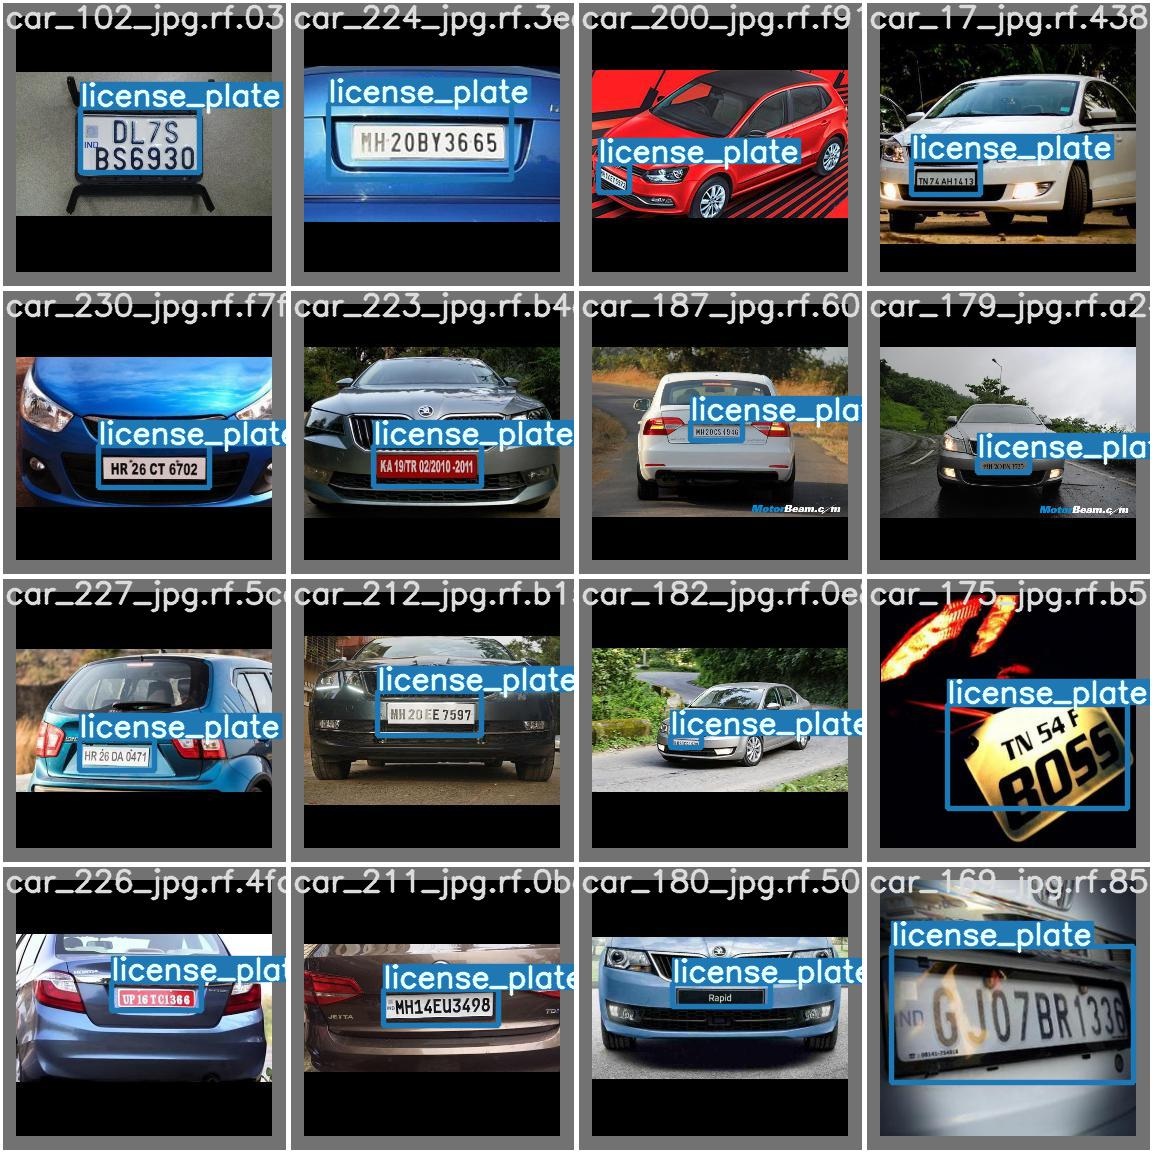

In [20]:
print("GROUND TRUTH TRAINING DATA:")
Image(filename='/content/yolov5/runs/train/yolov5s_results/test_batch0_labels.jpg', width=900)

In [ ]:
%ls runs/

train/


In [ ]:
%ls runs/train/yolov5s_results/weights

best.pt  last.pt


In [ ]:
!zip -r /content/Runs.zip /content/yolov5/runs

  adding: content/yolov5/runs/ (stored 0%)
  adding: content/yolov5/runs/train/ (stored 0%)
  adding: content/yolov5/runs/train/yolov5s_results/ (stored 0%)
  adding: content/yolov5/runs/train/yolov5s_results/train_batch1.jpg (deflated 6%)
  adding: content/yolov5/runs/train/yolov5s_results/opt.yaml (deflated 48%)
  adding: content/yolov5/runs/train/yolov5s_results/confusion_matrix.png (deflated 38%)
  adding: content/yolov5/runs/train/yolov5s_results/labels_correlogram.jpg (deflated 26%)
  adding: content/yolov5/runs/train/yolov5s_results/P_curve.png (deflated 20%)
  adding: content/yolov5/runs/train/yolov5s_results/train_batch2.jpg (deflated 5%)
  adding: content/yolov5/runs/train/yolov5s_results/hyp.yaml (deflated 44%)
  adding: content/yolov5/runs/train/yolov5s_results/results.png (deflated 9%)
  adding: content/yolov5/runs/train/yolov5s_results/PR_curve.png (deflated 29%)
  adding: content/yolov5/runs/train/yolov5s_results/train_batch0.jpg (deflated 6%)
  adding: content/yolov5/ru

In [ ]:
exit()

In [21]:
zip = ZipFile('/content/Runs.zip' , 'r')

In [22]:
zip.extractall('/content/')

In [23]:
zip.close()

In [24]:
%cd /content/yolov5/
!python detect.py --weights /content/content/yolov5/runs/train/yolov5s_results/weights/best.pt --img 256 --conf 0.4 --source ../test/images

/content/yolov5
Namespace(agnostic_nms=False, augment=False, classes=None, conf_thres=0.4, device='', exist_ok=False, img_size=256, iou_thres=0.45, name='exp', project='runs/detect', save_conf=False, save_txt=False, source='../test/images', update=False, view_img=False, weights=['/content/content/yolov5/runs/train/yolov5s_results/weights/best.pt'])
YOLOv5 v4.0-126-g886f1c0 torch 1.8.0+cu101 CPU

Fusing layers... 
Model Summary: 232 layers, 7246518 parameters, 0 gradients, 16.8 GFLOPS
image 1/30 /content/yolov5/../test/images/car_104_jpg.rf.4c68b6b953c4a63ce5e77580406330f9.jpg: 256x256 Done. (0.114s)
image 2/30 /content/yolov5/../test/images/car_113_jpg.rf.17c823f817d4681ca09865d7a17521cf.jpg: 256x256 1 license_plate, Done. (0.093s)
image 3/30 /content/yolov5/../test/images/car_122_jpg.rf.6913d4c557490a4fdcb3bc291fdbbc06.jpg: 256x256 1 license_plate, Done. (0.086s)
image 4/30 /content/yolov5/../test/images/car_13_jpg.rf.18bd769d9bc52c91b4fa67489a503130.jpg: 256x256 1 license_plate, Done

In [25]:
!zip -r /content/Output.zip /content/yolov5/runs/detect/exp

  adding: content/yolov5/runs/detect/exp/ (stored 0%)
  adding: content/yolov5/runs/detect/exp/car_241_jpg.rf.e970cbcdd015f02193df790dafe3cee2.jpg (deflated 7%)
  adding: content/yolov5/runs/detect/exp/car_146_jpg.rf.fe1196d66e7790557e639fa35f92a797.jpg (deflated 7%)
  adding: content/yolov5/runs/detect/exp/car_204_jpg.rf.a31d1c40eec08681b18d69d7ba11de68.jpg (deflated 5%)
  adding: content/yolov5/runs/detect/exp/car_276_jpg.rf.41cbecbb7d787f22e2e5c9b3dc091fe4.jpg (deflated 5%)
  adding: content/yolov5/runs/detect/exp/car_251_jpg.rf.c179f58f4345e9c801f0ad7e61ffe343.jpg (deflated 7%)
  adding: content/yolov5/runs/detect/exp/car_317_jpg.rf.132aecc0503a1bb2d482ede85ddcfc4c.jpg (deflated 8%)
  adding: content/yolov5/runs/detect/exp/car_104_jpg.rf.4c68b6b953c4a63ce5e77580406330f9.jpg (deflated 8%)
  adding: content/yolov5/runs/detect/exp/car_335_jpg.rf.82786b3bb9e1d790490d96fb23cb55ba.jpg (deflated 5%)
  adding: content/yolov5/runs/detect/exp/car_122_jpg.rf.6913d4c557490a4fdcb3bc291fdbbc06.j